In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 04: XGBoost, no NAICS
XGBoost model, but without NAICS features

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve
from sklearn.ensemble import GradientBoostingClassifier

## Import Processed Datasets

In [5]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [6]:
test_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet'))

In [7]:
val_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_val.parquet'))

#### Set the predictor features.  Do not include any NAICS features.

In [8]:
predictor_features = setup.predictor_features 
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag']


In [9]:
with open(Path(setup.temp_path).joinpath('04_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [10]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.20301083058320588, pos wt: 3.9258455675848323


##### Do a simple hyperparameter search

In [11]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 10)

In [12]:
hyperparam_serarch = {'max_depth': [4, 5, 6],
                      'min_child_weight': [1, 10, 50],
                      'scale_pos_weight': list(np.linspace(1, scale_pos_wt, 3)),
                      'gamma': [0, 0.5, 1, 2],
                      'subsample': [0.5, 0.8, 1.0],
                      'learning_rate': [0.01, 0.1, 0.3],
                      'reg_alpha': [0, 0.001, 0.01, 0.1],
                      'reg_lambda': [0.001, 0.01, 0.1, 0.5]
                     }

In [13]:
# Set up a cross validation without the final fit; don't use early stopping yet
random_search = RandomizedSearchCV(xgb_model, hyperparam_serarch,
                                   n_iter=20, 
                                   n_jobs=-1,
                                   random_state=53,
                                   verbose = 0,
                                   refit = False)

In [14]:
# Do the cross validation parameter search
rs_fit = random_search.fit(train_df[predictor_features], train_df['target']);

In [15]:
print(random_search.best_params_)

{'subsample': 0.8, 'scale_pos_weight': 1.0, 'reg_lambda': 0.001, 'reg_alpha': 0.01, 'min_child_weight': 50, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.5}


In [16]:
pd.DataFrame({k:[random_search.best_params_[k]] for k in random_search.best_params_.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('04_REPORT_fit_parameter_selected.csv'), index=False)

##### Do a final fit with the full training data and early stopping

In [17]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 20)

In [18]:
xgb_model = xgb_model.set_params(**random_search.best_params_)

In [19]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.48877	validation_1-logloss:0.48884
[1]	validation_0-logloss:0.47796	validation_1-logloss:0.47808
[2]	validation_0-logloss:0.47071	validation_1-logloss:0.47086
[3]	validation_0-logloss:0.46645	validation_1-logloss:0.46673
[4]	validation_0-logloss:0.46388	validation_1-logloss:0.46425
[5]	validation_0-logloss:0.46220	validation_1-logloss:0.46259
[6]	validation_0-logloss:0.46092	validation_1-logloss:0.46138
[7]	validation_0-logloss:0.46013	validation_1-logloss:0.46068
[8]	validation_0-logloss:0.45961	validation_1-logloss:0.46022
[9]	validation_0-logloss:0.45915	validation_1-logloss:0.45988
[10]	validation_0-logloss:0.45888	validation_1-logloss:0.45972
[11]	validation_0-logloss:0.45846	validation_1-logloss:0.45926
[12]	validation_0-logloss:0.45828	validation_1-logloss:0.45915
[13]	validation_0-logloss:0.45813	validation_1-logloss:0.45902
[14]	validation_0-logloss:0.45781	validation_1-logloss:0.45875
[15]	validation_0-logloss:0.45772	validation_1-logloss:0.45867
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
train_df['target'].value_counts()

target
0    356455
1     90797
Name: count, dtype: int64

##### Save the model

In [21]:
xgb_model.save_model(Path(setup.temp_path).joinpath('04_MODEL_xgboost.json'))

In [22]:
with open(Path(setup.temp_path).joinpath('04_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [23]:
pred_df = pd.concat([pd.DataFrame({'actual': df['target'], 
                                          'predict': xgb_model.predict_proba(df[predictor_features])[:,1]}) \
                            for df in [train_df, test_df, val_df]], 
                           keys = ['train', 'test', 'val'], names=['dset', 'index']) 

In [24]:
pred_df.groupby(['actual'])['predict'].agg(['mean', 'std'])

,mean,std
actual,,
0,0.186070,0.111684
1,0.269774,0.100034


## Decision Threshold
Max f1, on training data

In [25]:
pred_train_df = pred_df[pred_df.index.get_level_values(0) == 'train']

In [26]:
def get_f1_sing(actual, pred_prob, thresh):
    return f1_score(pred_train_df['actual'], 
         np.where(pred_train_df['predict'] > thresh, 1, 0))

In [27]:
def get_f1_frame(actual, pred_prob, num_pts = 51):
    thresh_ser = pd.Series(np.linspace(0, 1, num_pts))
    return pd.DataFrame({'thresh': thresh_ser,
                         'f1': thresh_ser.apply(lambda x: get_f1_sing(actual, pred_prob, x))})

In [28]:
thresh_df = get_f1_frame(pred_train_df['actual'], pred_train_df['predict'])

In [29]:
thresh_df.to_csv(Path(setup.temp_path).joinpath('04_REPORT_thresh_tune.csv'), index=False)

In [30]:
thresh_head = thresh_df.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.431986
10,0.20,0.431048


##### Apply decision threshold
All datasets

In [31]:
pred_df['predict_bin'] = np.where(pred_df['predict'] >= best_thresh, 1, 0)

In [32]:
pred_df['predict_bin'].value_counts()

predict_bin
0    360292
1    327789
Name: count, dtype: int64

In [33]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('04_DATA_combined_predictions.parquet'))

In [34]:
pred_df.head(10)

actual   predict  predict_bin
dset  index                                
train 538061       0  0.123892            0
      220915       0  0.093102            0
      237886       1  0.347072            1
      852933       0  0.048651            0
      370109       0  0.153332            0
      825551       0  0.049011            0
      462351       0  0.124730            0
      886865       1  0.062097            0
      687784       0  0.148043            0
      402987       0  0.205671            0

## Metrics

##### Classification metrics
Accuracy, f1, precision, recall

In [35]:
def dset_metrics(df, metrics_list = [accuracy_score, f1_score, precision_score, recall_score],
                actual_col = 'actual', predict_col = 'predict_bin'):
    return pd.Series([m(df[actual_col], df[predict_col]) for m in metrics_list],
                               index=[m.__name__ for m in metrics_list]) 

In [36]:
metrics_class_df = pred_df.groupby('dset').apply(dset_metrics)

##### AUC scores
PR-AUC and ROC-AUC

In [37]:
metrics_auc_df = pd.concat([pd.DataFrame({metf.__name__: [metf(df['target'], xgb_model.predict_proba(df[predictor_features])[:,1])] \
              for metf in [average_precision_score, roc_auc_score]})
           for df in [train_df, test_df, val_df]], keys = ['train', 'test', 'val']) \
    .reset_index(level=1, drop=True)

In [38]:
metrics_df = pd.concat([metrics_class_df, metrics_auc_df], axis=1)
metrics_df.to_csv(Path(setup.temp_path).joinpath('04_REPORT_metrics.csv'))

In [39]:
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
test,0.613397,0.430057,0.306872,0.718459,0.351846,0.707392
train,0.614070,0.431986,0.308030,0.722887,0.354809,0.709215
val,0.612133,0.430271,0.306544,0.721467,0.353931,0.707462


## Lift
Test data

In [40]:
pred_test_df = pred_df[pred_df.index.get_level_values(0) == 'test']

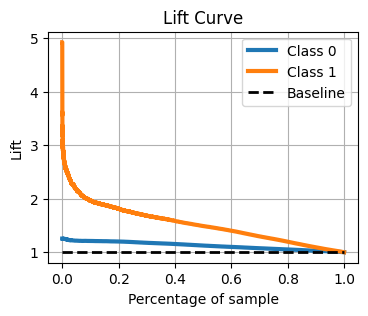

In [41]:
plot_lift_curve(pred_test_df['actual'].sort_index(), 
                xgb_model.predict_proba(test_df[predictor_features].sort_index()), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [42]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [43]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('04_REPORT_importance_gain.csv'), index=True)

In [44]:
feat_impgain.head()

,importance
urban_flag,980.858704
LowDoc,119.562660
DisbursementGross,82.998650
new_business,32.851250
CreateJob,22.364008


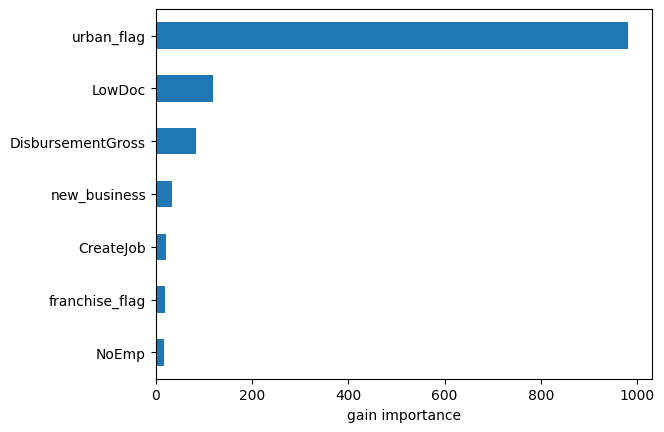

In [45]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_importance_gain.png'))

##### Permutation Importance

In [46]:
perm_importance = permutation_importance(xgb_model, train_df[predictor_features], train_df['target'])

In [47]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [48]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.002714,0.002714
1,CreateJob,0.002123,0.002123
2,LowDoc,0.000506,0.000506
5,urban_flag,0.000417,0.000417
0,NoEmp,0.000289,0.000289


In [49]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('04_DATA_importance_perturb.csv'),
            index=False)

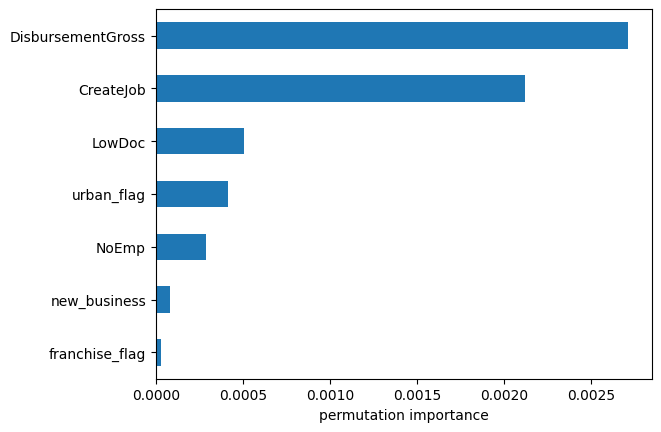

In [50]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_importance_perturb.png'))